## Imports

In [3]:
import os
import multiprocessing
import rasterio
import tensorflow as tf
from glob import glob
import pickle
import numpy as np
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import keras
import pandas as pd
import matplotlib.pyplot as plt

### Test with Simple CNN and Data Loader 

In [4]:
import boto3
import rasterio as rio
import numpy as np
import io

In [5]:
from data_loader import DataLoader

In [6]:
gen = DataLoader(label_file_path_train="labels_test_v1.csv", #or labels.csv
                        label_file_path_val="val_labels.csv",
                        bucket_name='canopy-production-ml',
                        data_extension_type='.tif',
                        training_data_shape=(100, 100, 18),
                        shuffle_and_repeat=False,
                        enable_just_shuffle=True,
                        enable_just_repeat=False,
                        training_data_shuffle_buffer_size=10,
                        data_repeat_count=None,
                        training_data_batch_size=20,
                        normalization_value=255.0,  #normalization TODO double check other channels than RGB 
                        training_data_type=tf.float32,
                        label_data_type=tf.uint8,
                        enable_data_prefetch=False,
                        data_prefetch_size=tf.data.experimental.AUTOTUNE,
                        num_parallel_calls=int(2))
# TODO add data augmentation in DataLoader 

no_of_val_imgs = len(gen.validation_filenames)
no_of_train_imgs = len(gen.training_filenames)
print("Validation on {} images ".format(str(no_of_val_imgs)))
print("Training on {} images ".format(str(no_of_train_imgs)))

Validation on 55 images 
Training on 100 images 


In [ ]:
# def Simple_CNN(numclasses, input_shape): #TODO use a more complex CNN
#         model = Sequential([
#             layers.Input(input_shape),
#             layers.Conv2D(16, 3, padding='same', activation='relu'),
#             layers.MaxPooling2D(),
#             layers.Conv2D(32, 3, padding='same', activation='relu'),
#             layers.MaxPooling2D(),
#             layers.Conv2D(64, 3, padding='same', activation='relu'),
#             layers.MaxPooling2D(),
#             layers.Flatten(),
#             layers.Dense(128, activation='relu'),
#             layers.Dense(numclasses)
#         ])
#         return model

# model_simpleCNN = Simple_CNN(10, input_shape=(100, 100, 18))
# callbacks_list = []

# model_simpleCNN.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#           optimizer=keras.optimizers.Adam()) #TODO add callbacks to save checkpoints and maybe lr reducer,etc 

# epochs = 10
# history = model_simpleCNN.fit(gen.training_dataset, validation_data=gen.validation_dataset, epochs=epochs)


Epoch 1/10
5/5 [==============================] - 86s 18s/step - loss: 8.7035 - val_loss: 1.5012
Epoch 2/10
5/5 [==============================] - 81s 17s/step - loss: 1.4694 - val_loss: 0.8578
Epoch 3/10
5/5 [==============================] - 82s 17s/step - loss: 0.6244 - val_loss: 0.2065
Epoch 4/10
5/5 [==============================] - 86s 17s/step - loss: 0.1674 - val_loss: 0.2439
Epoch 5/10
5/5 [==============================] - 84s 17s/step - loss: 0.1836 - val_loss: 0.2107
Epoch 6/10
5/5 [==============================] - 87s 18s/step - loss: 0.1562 - val_loss: 0.1956
Epoch 7/10
5/5 [==============================] - 82s 17s/step - loss: 0.1483 - val_loss: 0.1829
Epoch 8/10
5/5 [==============================] - 83s 17s/step - loss: 0.1326 - val_loss: 0.1831
Epoch 9/10
5/5 [==============================] - 87s 17s/step - loss: 0.1373 - val_loss: 0.1843
Epoch 10/10
5/5 [==============================] - 83s 17s/step - loss: 0.1324 - val_loss: 0.1902


In [ ]:
# s3 = boto3.resource('s3')
# obj = s3.Object('canopy-production-ml', "chips/cloudfree-merge-polygons/split/test/100/100_1000_1000.tif")
# obj_bytes = io.BytesIO(obj.get()['Body'].read())
# with rasterio.open(obj_bytes) as src:
#     img_test = np.transpose(src.read(), (1, 2, 0))
# print(img_test.shape)

(100, 100, 18)


In [ ]:
# label_list = ['Habitation', 'ISL', 'Industrial_agriculture', 'Mining',
#     'Rainforest', 'River', 'Roads', 'Savannah', 'Shifting_cultivation',
#     'Water'
# ]
# # TODO Need to weight labels since they are pretty unbalanced (Rainforest is largely represented)

In [ ]:
# predictions = model_simpleCNN.predict(np.array([img_test]))
# highest_score_predictions = np.argmax(predictions) # TODO: read more about multi classes PER IMAGE classification, what is the threshold?

# print("This chip was predicted to belong to class {}".format(label_list[highest_score_predictions]))

This chip was predicted to belong to class Rainforest


In [ ]:
# print(predictions)
# predictions.argsort() 

[[-2020.7277        4.4248075 -1614.4033    -3687.283       157.33759
  -1660.8308     -644.8952    -2039.6393    -1582.1956    -1557.5543   ]]


array([[3, 7, 0, 5, 2, 8, 9, 6, 1, 4]])

In [ ]:
# model_simpleCNN.evaluate(gen.validation_dataset)

3/3 [==============================] - 35s 10s/step - loss: 0.1902


0.19022126495838165

In [7]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()



## PREPRODUCTION Candidate: ResNet50 pretrained on ImageNet

Build model

In [25]:
def define_model(numclasses,input_shape):
    # parameters for CNN
    input_tensor = Input(shape=input_shape)

    # introduce a additional layer to get from bands to 3 input channels
    input_tensor = Conv2D(3, (1, 1))(input_tensor)

    base_model_resnet50 = keras.applications.ResNet50(include_top=False,
                              weights='imagenet',
                              input_shape=(100, 100, 3))
    base_model = keras.applications.ResNet50(include_top=False,
                     weights=None,
                     input_tensor=input_tensor)

    for i, layer in enumerate(base_model_resnet50.layers):
        # we must skip input layer, which has no weights
        if i == 0:
            continue
        base_model.layers[i+1].set_weights(layer.get_weights())

    # add a global spatial average pooling layer
    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)

    # let's add a fully-connected layer
    top_model = Dense(2048, activation='relu')(top_model)
    top_model = Dense(2048, activation='relu')(top_model)
    # and a logistic layer
    predictions = Dense(numclasses, activation='softmax')(top_model)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    model.summary()
    return model

In [26]:
random_id = 1234 #TODO
checkpoint_file = 'checkpoint_{}.h5'.format(random_id)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath= checkpoint_file,
  format='h5',
  verbose=1,
  save_weights_only=True,
  monitor='val_loss',
  mode='min',
  save_best_only=True)

reducelronplateau = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss', factor=0.1, patience=10, verbose=1,
  mode='min', min_lr=1e-10)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=20, verbose=1)

callbacks_list = [model_checkpoint_callback, reducelronplateau, early_stop]

model = define_model(10, (100,100,18))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                          optimizer=keras.optimizers.Adam(),
                          metrics=[tf.metrics.BinaryAccuracy(name='accuracy')]) #TODO add callbacks to save checkpoints and maybe lr reducer, earlystop,etc 


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100, 100, 18 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 100, 100, 3)  57          input_5[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
____________________________________________________________________________________________

Start training

In [27]:
epochs = 20
history = model.fit(gen.training_dataset, validation_data=gen.validation_dataset, 
                    epochs=epochs, 
                    callbacks=callbacks_list)


Epoch 1/20
5/5 [==============================] - 13s 2s/step - loss: 0.7061 - accuracy: 0.8995 - val_loss: 0.6752 - val_accuracy: 0.9400

Epoch 00001: val_loss improved from inf to 0.67516, saving model to checkpoint_1234.h5
Epoch 2/20
5/5 [==============================] - 8s 2s/step - loss: 0.6762 - accuracy: 0.9385 - val_loss: 0.6752 - val_accuracy: 0.9400

Epoch 00002: val_loss did not improve from 0.67516
Epoch 3/20
5/5 [==============================] - 8s 2s/step - loss: 0.6753 - accuracy: 0.9370 - val_loss: 0.6752 - val_accuracy: 0.9400

Epoch 00003: val_loss did not improve from 0.67516
Epoch 4/20
5/5 [==============================] - 7s 1s/step - loss: 0.6763 - accuracy: 0.9366 - val_loss: 0.6752 - val_accuracy: 0.9400

Epoch 00004: val_loss did not improve from 0.67516
Epoch 5/20
5/5 [==============================] - 8s 2s/step - loss: 0.6774 - accuracy: 0.9354 - val_loss: 0.6752 - val_accuracy: 0.9400

Epoch 00005: val_loss did not improve from 0.67516
Epoch 6/20
5/5 [==

Evaluation

In [28]:
model.evaluate(gen.validation_dataset) 

3/3 [==============================] - 3s 588ms/step - loss: 0.6752 - accuracy: 0.9400


[0.6751586198806763, 0.9399999976158142]

In [29]:
s3 = boto3.resource('s3')
# TODO test on entire test dataset
obj = s3.Object('canopy-production-ml', "chips/cloudfree-merge-polygons/split/test/100/100_1000_1000.tif")
obj_bytes = io.BytesIO(obj.get()['Body'].read())
with rasterio.open(obj_bytes) as src:
    img_test = np.transpose(src.read(), (1, 2, 0))
print(img_test.shape)
label_list = ['Habitation', 'ISL', 'Industrial_agriculture', 'Mining',
    'Rainforest', 'River', 'Roads', 'Savannah', 'Shifting_cultivation',
    'Water'
]
# TODO Need to do data augmentation

(100, 100, 18)


In [30]:
predictions = model.predict(np.array([img_test]))
highest_score_predictions = np.argmax(predictions) # TODO: read more about multi classes PER IMAGE classification, what is the threshold?

print("This chip was predicted to belong to top 3 classes:")

top3 = np.argsort(predictions[0])[:-4:-1]
for i in range(3):
  print(label_list[top3[i]])

This chip was predicted to belong to top 3 classes:
Rainforest
Water
Shifting_cultivation


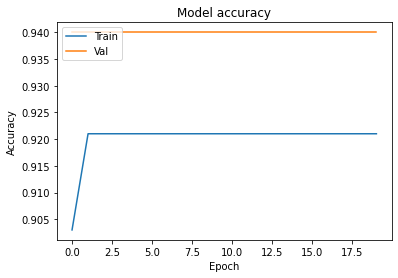

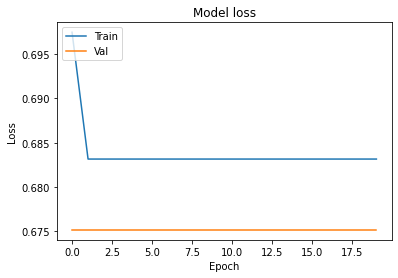

In [31]:
plot_learningCurve(history, 20)

Resnet not pre trained

In [32]:
def define_model_not_pretrained(numclasses,input_shape):
    # parameters for CNN
    input_tensor = Input(shape=input_shape)

    # introduce a additional layer to get from bands to 3 input channels
    input_tensor = Conv2D(3, (1, 1))(input_tensor)

    base_model_resnet50 = keras.applications.ResNet50(include_top=False,
                              weights=None,
                              input_shape=(100, 100, 3))
    base_model = keras.applications.ResNet50(include_top=False,
                     weights=None,
                     input_tensor=input_tensor)

    for i, layer in enumerate(base_model_resnet50.layers):
        # we must skip input layer, which has no weights
        if i == 0:
            continue
        base_model.layers[i+1].set_weights(layer.get_weights())

    # add a global spatial average pooling layer
    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)

    # let's add a fully-connected layer
    top_model = Dense(2048, activation='relu')(top_model)
    top_model = Dense(2048, activation='relu')(top_model)
    # and a logistic layer
    predictions = Dense(numclasses, activation='softmax')(top_model)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    model.summary()
    return model

In [33]:
random_id = 1235 #TODO 
checkpoint_file = 'checkpoint_{}.h5'.format(random_id)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath= checkpoint_file,
  format='h5',
  verbose=1,
  save_weights_only=True,
  monitor='val_loss',
  mode='min',
  save_best_only=True)

reducelronplateau = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss', factor=0.1, patience=10, verbose=1,
  mode='min', min_lr=1e-10)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=20, verbose=1)

callbacks_list = [model_checkpoint_callback, reducelronplateau, early_stop]

model = define_model(10, (100,100,18))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                          optimizer=keras.optimizers.Adam(),
                          metrics=[tf.metrics.BinaryAccuracy(name='accuracy')]) #TODO add callbacks to save checkpoints and maybe lr reducer, earlystop,etc 


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100, 100, 18 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 100, 100, 3)  57          input_7[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
____________________________________________________________________________________________

In [34]:
epochs = 20
history = model.fit(gen.training_dataset, validation_data=gen.validation_dataset, 
                    epochs=epochs, 
                    callbacks=callbacks_list)


Epoch 1/20
5/5 [==============================] - 13s 2s/step - loss: 0.7045 - accuracy: 0.9051 - val_loss: 0.6752 - val_accuracy: 0.9400

Epoch 00001: val_loss improved from inf to 0.67516, saving model to checkpoint_1235.h5
Epoch 2/20
5/5 [==============================] - 8s 1s/step - loss: 0.6783 - accuracy: 0.9348 - val_loss: 0.6752 - val_accuracy: 0.9400

Epoch 00002: val_loss did not improve from 0.67516
Epoch 3/20
5/5 [==============================] - 8s 2s/step - loss: 0.6768 - accuracy: 0.9362 - val_loss: 0.6752 - val_accuracy: 0.9400

Epoch 00003: val_loss did not improve from 0.67516
Epoch 4/20
5/5 [==============================] - 8s 2s/step - loss: 0.6771 - accuracy: 0.9358 - val_loss: 0.6752 - val_accuracy: 0.9400

Epoch 00004: val_loss did not improve from 0.67516
Epoch 5/20
5/5 [==============================] - 8s 1s/step - loss: 0.6781 - accuracy: 0.9345 - val_loss: 0.6752 - val_accuracy: 0.9400

Epoch 00005: val_loss did not improve from 0.67516
Epoch 6/20
5/5 [==

In [35]:
model.evaluate(gen.validation_dataset) 

3/3 [==============================] - 3s 623ms/step - loss: 0.6752 - accuracy: 0.9400


[0.6751586198806763, 0.9399999976158142]

In [36]:
predictions = model.predict(np.array([img_test]))
highest_score_predictions = np.argmax(predictions) # TODO: read more about multi classes PER IMAGE classification, what is the threshold?

print("This chip was predicted to belong to top 3 classes:")

top3 = np.argsort(predictions[0])[:-4:-1]
for i in range(3):
  print(label_list[top3[i]])

This chip was predicted to belong to top 3 classes:
Rainforest
Water
Shifting_cultivation


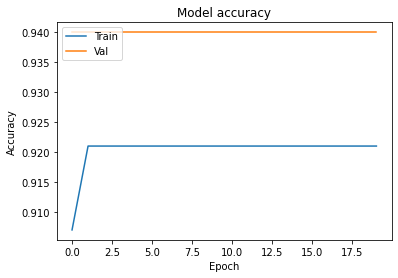

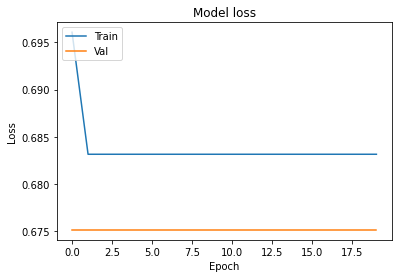

In [37]:
plot_learningCurve(history, 20)